In [ ]:
!pip3 install numpy
!pip3 install matplotlib
!pip3 install pandas

!pip3 install opencv-python

!pip3 install torch torchvision torchaudio

!pip3 install tensorflow
!pip3 install keras
!pip3 install tensorflow

!pip3 install gTTS
!pip3 install librosa
!pip3 install soundfile

In [1]:
from random import random
import time
import os
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from gtts import gTTS # for text-to-speech
# import soundfile as sf
from IPython.display import Audio
import librosa
import librosa.effects

In [2]:
# Make plots larger (default [6,4] on my machine)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12, 8]
# print(mpl.rcParams['figure.figsize'])

## Data Pre-Processing

In [3]:
# Data folder paths

datadir = Path("data/samples/")
# datadir_sharpened = Path("sharpened/samples/")

In [4]:
# Get images from data directory

images = list(datadir.glob("*.png")) # get images of format .png
print("Number of captcha images: ", len(images))

Number of captcha images:  1040


In [5]:
characters = set() # unique characters
captcha_size = [] # number of characters in each captcha
img_label_lst = [] # image-label info: list of tuples (image path, image label)

# Iterate over dataset
for img_path in images:
    label = img_path.name.split(".png")[0] # extract image label (name of file)
    captcha_size.append(len(label)) # length of this captcha
    img_label_lst.append((str(img_path), label))
    for ch in label: # store the characters present
        characters.add(ch)

characters = sorted(characters)
img_label_df = pd.DataFrame(img_label_lst, columns=["img_path", "label"], index=None) # convert to pd dataframe
img_label_df = img_label_df.sample(frac=1.).reset_index(drop=True) # shuffle the dataset

print("Number of captcha images: ", len(img_label_df))
img_label_df.head() # print top 5

Number of captcha images:  1040


,img_path,label
0,data/samples/x277e.png,x277e
1,data/samples/gfp54.png,gfp54
2,data/samples/neecd.png,neecd
3,data/samples/8y6b3.png,8y6b3
4,data/samples/474ff.png,474ff


### Removing Blur and Sharpening Images

(Optional)

In [6]:
print(img_label_df[img_label_df['label'] == '8n4n8'])
print(img_label_df.iloc[[0]]['img_path'])
testvar1234 = img_label_df['img_path'].values[0] # (img_label_df.iloc[[0]])['img_path']
print(testvar1234)
print(type(testvar1234))

                   img_path  label
520  data/samples/8n4n8.png  8n4n8
0    data/samples/x277e.png
Name: img_path, dtype: object
data/samples/x277e.png
<class 'str'>


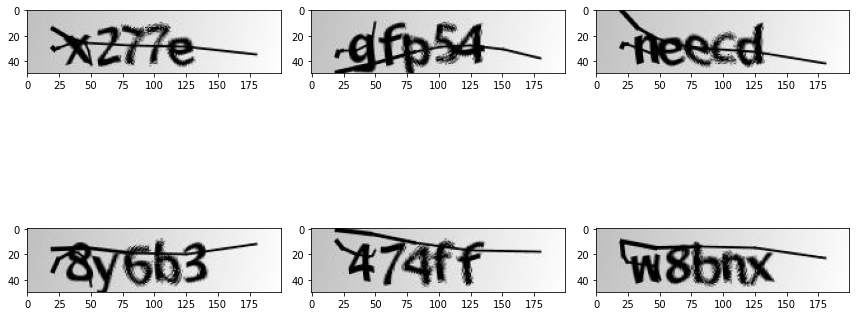

In [7]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_idx in range(0, 6, 1):
    # print(img_paths[img_index].shape)
    img = cv2.imread(img_label_df['img_path'].values[img_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img_idx % 3 == 0 and img_idx != 0:
        row += 1
    axes[row, img_idx % num_cols].imshow(img)
    # axes[row, img_index % num_cols].set_title(captcha_labels_train[img_index])

fig.tight_layout()
plt.show()

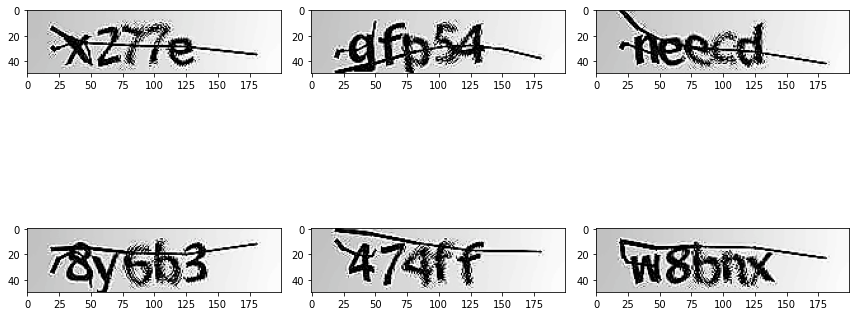

In [8]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_idx in range(0, 6, 1):
    img = cv2.imread(img_label_df['img_path'].values[img_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(img, -1, sharpen_kernel)
    sharpened_image = cv2.fastNlMeansDenoisingColored(sharpened_image,None,10,10,7,21)

    if img_idx % 3 == 0 and img_idx != 0:
        row += 1
    axes[row, img_idx % num_cols].imshow(sharpened_image)
    # axes[row, img_idx % num_cols].set_title(captcha_labels_train[img_idx])

fig.tight_layout()
plt.show()

The sharpening filter sharpens the edges of characters like '2', which were clear solid characters with soft edges in the sample.
However, it also accentuates the choppy edges in our captcha images. We are unable to remove this with the denoising filter since OpenCV sees it as relevant data, not noise.

Other sharpening filters seem to do the same.

So we will not use sharpening. However, the code is here in case we ever need to run the program on a different dataset

## Building the Dataloader

In [ ]:
class CaptchaModel(nn.Module):
    '''
    Neural Net to detect CAPTCHA label
    '''
    def __init__(self, data, labels, char_map, batch_size=16, img_width=200, img_height=50, downsample_factor=4, max_length=5, shuffle=True):
        super(CaptchaModel, self).__init__()

## Text-to-Speech

### Hugging Face Version (Not Using)

In [9]:
# from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
# from datasets import load_dataset
# import torch
# import soundfile as sf

# processor = SpeechT5Processor.from_pretrained('microsoft/speecht5_tts')
# model = SpeechT5ForTextToSpeech.from_pretrained('microsoft/speecht5_tts')
# vocoder = SpeechT5HifiGan.from_pretrained('microsoft/speecht5_hifigan')

# # inputs = processor(text="Work you stupid piece of crap", return_tensors="pt")
# inputs = processor(text="C.", return_tensors="pt")

# embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
# speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

# speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

# from IPython.display import Audio

# Audio(speech, rate=12000)
# # sf.write("testAudio.wav", speech.numpy())

### GTTS Version

In [10]:
def label2cleanSpeech(captcha_label:str, out_filename:str="captchaAudioClean.wav", language:str='en'):
    '''
    Input:
        captcha_label: string to convert to audio
        out_filename : file (with path) to save audio (.wav) file to
                     : "captchaAudioClean.wav" by default
        language     : language of text/audio
                     : "en" for English by default
    Returns:
        speech_obj   : gTTS audio object
    '''
    txt = ""
    for character in captcha_label:
        txt += character + "/"
    speech_obj = gTTS(text=txt, lang=language, slow=True) # slow=True for speech to be slow
    speech_obj.save(out_filename)

    return speech_obj


def cleanSpeech2captchaAudio(in_filename:str="captchaAudioClean.wav", out_filename:str="captchaAudioFinal.wav"):
    '''
    Input:
        in_filename  : file (with path: .wav or .mp3) to add noise to
                     : "captchaAudioClean.wav" by default
        out_filename : file (with path) to save final noisy captcha audio (.wav) file to
                     : "captchaAudioFinal.wav" by default
    Returns:
        Audio with pitch shift, noise, and stretch applied
    '''

    original_audio, sr = librosa.load(in_filename, sr=None)

    # Pitch shift
    pitch_shifted_audio = librosa.effects.pitch_shift(original_audio, sr=sr, n_steps=1.0)

    # Add Wald (inverse Gaussian) noise
    noise_audio = pitch_shifted_audio.copy()
    noise_amp = 0.005*np.random.wald(30,2)*np.amax(noise_audio)
    noise_audio = noise_audio.astype('float64') + noise_amp * np.random.normal(size=noise_audio.shape[0])

    # Stretch Audio
    input_length = len(noise_audio)
    stretch_audio = noise_audio.copy()
    stretch_audio = librosa.effects.time_stretch(stretch_audio.astype('float'), rate=1.1)
    if len(stretch_audio) > input_length:
        stretch_audio = stretch_audio[:input_length]
    else:
        stretch_audio = np.pad(stretch_audio, (0, max(0, input_length - len(stretch_audio))), "constant")

    # Audio at 80% of sampling rate
    final_audio = Audio(stretch_audio, rate=0.8*sr)
    # sf.write(out_filename, data=stretch_audio, samplerate=int(sr*0.8), subtype='PCM_24')
    with open(out_filename, 'wb') as f:
        f.write(final_audio.data)
    return final_audio

In [11]:
label2cleanSpeech("CN8p4")
cleanSpeech2captchaAudio()

## Command Line Interface

>> Welcome to our CAPTCH to Audio Convertor.
   Please a full path to the captcha image. Type "help" for available commands.

>> Please enter a pathname.
   Example: /Users/user/Downloads/filename.png
   Other commands:
     - "q" or "quit" to exit

*** Unknown syntax: siuuuuu





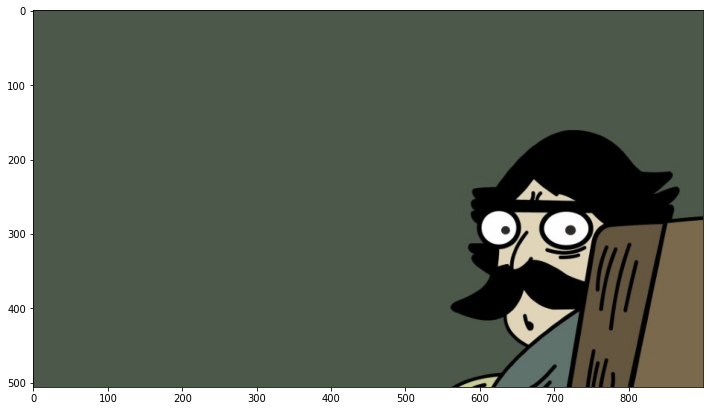

In [12]:
import cmd

class captcha2audioCLI(cmd.Cmd):
    prompt = '>> '
    intro = '''>> Welcome to our CAPTCH to Audio Convertor.\n   Please a full path to the captcha image. Type "help" for available commands.\n'''

    # Help
    def do_help(self, line):
        print(">> Please enter a pathname.\n   Example: /Users/user/Downloads/filename.png")
        print('''   Other commands:\n     - "q" or "quit" to exit''')
    
    # Read CAPTCHA image
    def do_image(self, line):
        while True:
            path = input("Please enter captcha image (full path): ")
            if path in ('quit', 'q', 'exit'):
                break
            try:
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
                break
            except:
                print("File does not exist. Please enter a valid path.")
    
    # Post command hook: empty line for better readability
    def postcmd(self, stop, line):
        print()
        return stop
    
    # Quit
    def do_quit(self, line):
        return True
    def do_q(self, line):
        return True
    def do_exit(self, line):
        return True

if __name__ == '__main__':
    captcha2audioCLI().cmdloop()